In [82]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from VisionUtils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
import tensorflow as tf

In [44]:
tf.enable_eager_execution()

In [45]:
feat1 = np.load("features/feat1.npy")
feat2 = np.load("features/feat2.npy")
labels = np.load("features/labels.npy")
feat3 = np.load("features/feat3.npy")
feat4 = np.load("features/feat4.npy")
labels34 = np.load("features/labels34.npy")

In [71]:
len(feat1.T)

128

In [142]:
f1 = [feat1[i1].reshape(-1,1) for i1 in range(len(feat1))]
f2 = [feat2[i2].reshape(-1,1) for i2 in range(len(feat2))]
cos_d = np.array(
    [ feat_distance_cosine_scalar(f1[i].T, f2[i]) for i in range(len(feat1))]).reshape(-1,1)
eucl_d = np.array([ np.linalg.norm(f1[i]- f2[i]) for i in range(len(feat1))]).reshape(-1,1)
sqr_diff = np.power(np.abs(feat1-feat2), 2)

data_dict = { "labels": labels,
             "cosine_distance": cos_d, 
             "Eucledian_distance": eucl_d,
             "sqaured_difference":sqr_diff}
data = np.hstack([cos_d,eucl_d, sqr_diff])

In [143]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
feats = SelectKBest(chi2, k = int(0.8*(len(data.T)))).fit_transform(scaled_data, labels)

In [144]:
eucl_d[:100].shape

(100, 1)

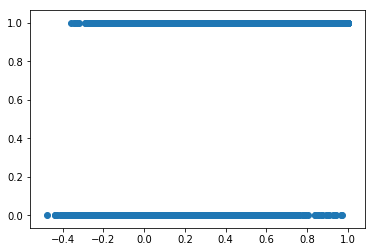

In [145]:
plt.scatter(cos_d, labels)

In [146]:

xtrain, xtest, ytrain, ytest = train_test_split(feats, labels, shuffle = True, random_state = 42)

In [184]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.regularizers import l1, l2
he_init = tf.keras.initializers.VarianceScaling()

model = Sequential()
model.add(Dense(20, activation = 'relu', kernel_initializer = he_init, 
                kernel_regularizer = l1(0.001), 
                #input_shape = (1,128)
               ))
model.add(Dense(5, activation = 'relu',kernel_initializer = he_init))
model.add(Dense(1, activation = "sigmoid", kernel_initializer = he_init))

In [185]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
mcp = ModelCheckpoint("models_chpt/best_modelD.hdf5",verbose = 1, 
                      monitor = "val_loss", save_best_only = True, save_weights_only = True)
red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor =0.5)
opt = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer = opt, loss = "binary_crossentropy", 
              metrics = ["accuracy"] )

In [186]:
bz = 1000
epochs = 400
history = model.fit(
    xtrain,
    ytrain,
    epochs = epochs,
    batch_size = bz,
    validation_data =(xtest, ytest),
    callbacks = [mcp, red_lr]
)


Train on 37500 samples, validate on 12500 samples
Epoch 1/400
31000/37500 [=======================>......] - ETA: 0s - loss: 0.6674 - acc: 0.7489
Epoch 00001: val_loss improved from inf to 0.45829, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 8us/sample - loss: 0.6337 - acc: 0.7631 - val_loss: 0.4583 - val_acc: 0.8310
Epoch 2/400
29000/37500 [======================>.......] - ETA: 0s - loss: 0.4300 - acc: 0.8302
Epoch 00002: val_loss improved from 0.45829 to 0.40375, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 3us/sample - loss: 0.4229 - acc: 0.8330 - val_loss: 0.4038 - val_acc: 0.8321
Epoch 3/400
28000/37500 [=====================>........] - ETA: 0s - loss: 0.4004 - acc: 0.8346
Epoch 00003: val_loss improved from 0.40375 to 0.40225, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 3us/sample - loss: 0.4011 - acc: 0.8334 - val_loss: 0.4023 

Epoch 00027: val_loss improved from 0.37683 to 0.37668, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 3us/sample - loss: 0.3753 - acc: 0.8339 - val_loss: 0.3767 - val_acc: 0.8318
Epoch 28/400
28000/37500 [=====================>........] - ETA: 0s - loss: 0.3719 - acc: 0.8365
Epoch 00028: val_loss improved from 0.37668 to 0.37596, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 3us/sample - loss: 0.3747 - acc: 0.8339 - val_loss: 0.3760 - val_acc: 0.8311
Epoch 29/400
32000/37500 [========================>.....] - ETA: 0s - loss: 0.3728 - acc: 0.8332
Epoch 00029: val_loss improved from 0.37596 to 0.37385, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 3us/sample - loss: 0.3742 - acc: 0.8324 - val_loss: 0.3738 - val_acc: 0.8306
Epoch 30/400
34000/37500 [==========================>...] - ETA: 0s - loss: 0.3734 - acc: 0.8340
Epoch 00030: val_loss imp

Epoch 55/400
30000/37500 [=======================>......] - ETA: 0s - loss: 0.3613 - acc: 0.8364
Epoch 00055: val_loss improved from 0.36473 to 0.36380, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3621 - acc: 0.8361 - val_loss: 0.3638 - val_acc: 0.8328
Epoch 56/400
30000/37500 [=======================>......] - ETA: 0s - loss: 0.3667 - acc: 0.8333
Epoch 00056: val_loss did not improve from 0.36380
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3668 - acc: 0.8331 - val_loss: 0.3767 - val_acc: 0.8266
Epoch 57/400
31000/37500 [=======================>......] - ETA: 0s - loss: 0.3652 - acc: 0.8313
Epoch 00057: val_loss did not improve from 0.36380
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3662 - acc: 0.8317 - val_loss: 0.3730 - val_acc: 0.8272
Epoch 58/400
32000/37500 [========================>.....] - ETA: 0s - loss: 0.3669 - acc: 0.8329
Epoch 00058: val_loss did no

Epoch 84/400
35000/37500 [===========================>..] - ETA: 0s - loss: 0.3576 - acc: 0.8357
Epoch 00084: val_loss improved from 0.35954 to 0.35893, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 3us/sample - loss: 0.3566 - acc: 0.8363 - val_loss: 0.3589 - val_acc: 0.8318
Epoch 85/400
33000/37500 [=========================>....] - ETA: 0s - loss: 0.3576 - acc: 0.8331
Epoch 00085: val_loss did not improve from 0.35893
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3582 - acc: 0.8335 - val_loss: 0.3621 - val_acc: 0.8306
Epoch 86/400
35000/37500 [===========================>..] - ETA: 0s - loss: 0.3610 - acc: 0.8338
Epoch 00086: val_loss did not improve from 0.35893
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3593 - acc: 0.8343 - val_loss: 0.3654 - val_acc: 0.8300
Epoch 87/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3577 - acc: 0.8344
Epoch 00087: val_loss did no

Epoch 113/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3529 - acc: 0.8363
Epoch 00113: val_loss improved from 0.35715 to 0.35632, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 3us/sample - loss: 0.3522 - acc: 0.8371 - val_loss: 0.3563 - val_acc: 0.8318
Epoch 114/400
35000/37500 [===========================>..] - ETA: 0s - loss: 0.3513 - acc: 0.8381
Epoch 00114: val_loss did not improve from 0.35632
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3517 - acc: 0.8373 - val_loss: 0.3570 - val_acc: 0.8320
Epoch 115/400
35000/37500 [===========================>..] - ETA: 0s - loss: 0.3517 - acc: 0.8367
Epoch 00115: val_loss did not improve from 0.35632
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3524 - acc: 0.8362 - val_loss: 0.3579 - val_acc: 0.8295
Epoch 116/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3531 - acc: 0.8371
Epoch 00116: val_loss im

Epoch 142/400
37000/37500 [============================>.] - ETA: 0s - loss: 0.3510 - acc: 0.8369
Epoch 00142: val_loss did not improve from 0.35526
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3507 - acc: 0.8372 - val_loss: 0.3560 - val_acc: 0.8318
Epoch 143/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3514 - acc: 0.8374
Epoch 00143: val_loss did not improve from 0.35526
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3509 - acc: 0.8377 - val_loss: 0.3560 - val_acc: 0.8321
Epoch 144/400
35000/37500 [===========================>..] - ETA: 0s - loss: 0.3500 - acc: 0.8371
Epoch 00144: val_loss did not improve from 0.35526
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3508 - acc: 0.8376 - val_loss: 0.3565 - val_acc: 0.8318
Epoch 145/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3576 - acc: 0.841 - ETA: 0s - loss: 0.3509 - acc: 0.8375
Epoch 00145: val_loss did not improv

36000/37500 [===========================>..] - ETA: 0s - loss: 0.3496 - acc: 0.8379
Epoch 00170: val_loss did not improve from 0.35475
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3497 - acc: 0.8378 - val_loss: 0.3548 - val_acc: 0.8322
Epoch 171/400
37000/37500 [============================>.] - ETA: 0s - loss: 0.3494 - acc: 0.8382
Epoch 00171: val_loss did not improve from 0.35475
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3498 - acc: 0.8380 - val_loss: 0.3548 - val_acc: 0.8326
Epoch 172/400
33000/37500 [=========================>....] - ETA: 0s - loss: 0.3487 - acc: 0.8381
Epoch 00172: val_loss improved from 0.35475 to 0.35475, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 3us/sample - loss: 0.3497 - acc: 0.8380 - val_loss: 0.3548 - val_acc: 0.8327
Epoch 173/400
37000/37500 [============================>.] - ETA: 0s - loss: 0.3496 - acc: 0.8379
Epoch 00173: val_loss did not improve 

36000/37500 [===========================>..] - ETA: 0s - loss: 0.3501 - acc: 0.8376
Epoch 00198: val_loss did not improve from 0.35462
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3494 - acc: 0.8379 - val_loss: 0.3546 - val_acc: 0.8321
Epoch 199/400
37000/37500 [============================>.] - ETA: 0s - loss: 0.3497 - acc: 0.8380
Epoch 00199: val_loss improved from 0.35462 to 0.35462, saving model to models_chpt/best_modelD.hdf5
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3494 - acc: 0.8380 - val_loss: 0.3546 - val_acc: 0.8326
Epoch 200/400
34000/37500 [==========================>...] - ETA: 0s - loss: 0.3501 - acc: 0.8379
Epoch 00200: val_loss did not improve from 0.35462
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3494 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8321
Epoch 201/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3497 - acc: 0.8383
Epoch 00201: val_loss did not improve 

Epoch 227/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3502 - acc: 0.8380
Epoch 00227: val_loss did not improve from 0.35459
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8382 - val_loss: 0.3546 - val_acc: 0.8322
Epoch 228/400
35000/37500 [===========================>..] - ETA: 0s - loss: 0.3492 - acc: 0.8380
Epoch 00228: val_loss did not improve from 0.35459
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8383 - val_loss: 0.3546 - val_acc: 0.8323
Epoch 229/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3492 - acc: 0.8383
Epoch 00229: val_loss did not improve from 0.35459
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8382 - val_loss: 0.3546 - val_acc: 0.8322
Epoch 230/400
 1000/37500 [..............................] - ETA: 0s - loss: 0.3507 - acc: 0.8300
Epoch 00230: val_loss improved from 0.35459 to 0.35458, saving model to mo

36000/37500 [===========================>..] - ETA: 0s - loss: 0.3500 - acc: 0.8379
Epoch 00256: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8323
Epoch 257/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3505 - acc: 0.8376
Epoch 00257: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8382 - val_loss: 0.3546 - val_acc: 0.8323
Epoch 258/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3491 - acc: 0.8382
Epoch 00258: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8382 - val_loss: 0.3546 - val_acc: 0.8323
Epoch 259/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3491 - acc: 0.8386
Epoch 00259: val_loss did not improve from 0.35458
37500/37500 [========================

Epoch 286/400
35000/37500 [===========================>..] - ETA: 0s - loss: 0.3485 - acc: 0.8385
Epoch 00286: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 287/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3499 - acc: 0.8379
Epoch 00287: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 288/400
34000/37500 [==========================>...] - ETA: 0s - loss: 0.3487 - acc: 0.8382
Epoch 00288: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 289/400
34000/37500 [==========================>...] - ETA: 0s - loss: 0.3479 - acc: 0.8390
Epoch 00289: val_loss did not improve from 0.35458
37500/37500 [==========

Epoch 316/400
35000/37500 [===========================>..] - ETA: 0s - loss: 0.3501 - acc: 0.8375
Epoch 00316: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 317/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3497 - acc: 0.8381
Epoch 00317: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 318/400
37000/37500 [============================>.] - ETA: 0s - loss: 0.3489 - acc: 0.8384
Epoch 00318: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 319/400
37000/37500 [============================>.] - ETA: 0s - loss: 0.3500 - acc: 0.8377
Epoch 00319: val_loss did not improve from 0.35458
37500/37500 [==========

Epoch 346/400
33000/37500 [=========================>....] - ETA: 0s - loss: 0.3480 - acc: 0.8393
Epoch 00346: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 347/400
36000/37500 [===========================>..] - ETA: 0s - loss: 0.3494 - acc: 0.8382
Epoch 00347: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 348/400
37000/37500 [============================>.] - ETA: 0s - loss: 0.3492 - acc: 0.8381
Epoch 00348: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 349/400
37000/37500 [============================>.] - ETA: 0s - loss: 0.3493 - acc: 0.8382
Epoch 00349: val_loss did not improve from 0.35458
37500/37500 [==========

Epoch 376/400
33000/37500 [=========================>....] - ETA: 0s - loss: 0.3506 - acc: 0.8370
Epoch 00376: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 377/400
33000/37500 [=========================>....] - ETA: 0s - loss: 0.3503 - acc: 0.8369
Epoch 00377: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 378/400
32000/37500 [========================>.....] - ETA: 0s - loss: 0.3488 - acc: 0.8385
Epoch 00378: val_loss did not improve from 0.35458
37500/37500 [==============================] - 0s 2us/sample - loss: 0.3493 - acc: 0.8381 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 379/400
32000/37500 [========================>.....] - ETA: 0s - loss: 0.3505 - acc: 0.8367
Epoch 00379: val_loss did not improve from 0.35458
37500/37500 [==========

Text(0.5, 1.0, 'Loss Vs # of epochs')

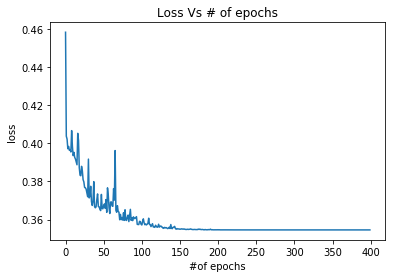

In [187]:
%matplotlib inline 
plt.plot( [i for i in range(epochs)], history.history['val_loss'], label = "validation loss")
plt.xlabel("#of epochs")
plt.ylabel("loss")
plt.title("Loss Vs # of epochs")

Text(0.5, 1.0, 'Loss Vs # of epochs')

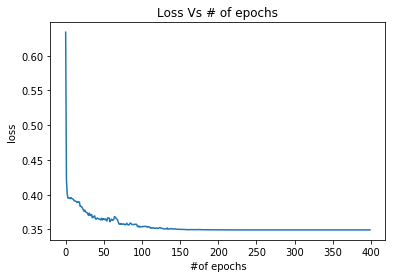

In [188]:
plt.plot([i for i in range(epochs)], history.history['loss'], label = "Train loss")
plt.xlabel("#of epochs")
plt.ylabel("loss")
plt.title("Loss Vs # of epochs")

Text(0.5, 1.0, 'Learning rate Vs # of epochs')

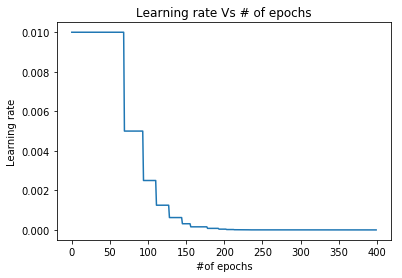

In [189]:
plt.plot([i for i in range(epochs)], history.history['lr'], label = "Train loss")
plt.xlabel("#of epochs")
plt.ylabel("Learning rate")
plt.title("Learning rate Vs # of epochs")

In [190]:
model.evaluate(xtest, ytest)

12500/12500 [==============================] - 0s 15us/sample - loss: 0.3546 - acc: 0.8324


[0.3545808448839188, 0.8324]

In [191]:
model_best = model

In [192]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [193]:
model_best.load_weights("models_chpt/best_modelD.hdf5")

In [194]:
model_best.evaluate(xtest, ytest)

12500/12500 [==============================] - 0s 12us/sample - loss: 0.3546 - acc: 0.8323


[0.35458033203601835, 0.83232]